In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Load LULESH data

In [2]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [2,4,6,8,9,10,12]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_gpu/lulesh_27/lulesh_{spread}/lulesh_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([spread, size, float(line.split()[-2])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'lulesh_size', 'time'])
normal_lulesh = lulesh_time.loc[lulesh_time['spread'] == 9]
#print(normal_lulesh)

avg_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()


# Load GPU Data

In [3]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline_gpu/{app}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            line = fp.readline()
            #print(line)
            data.append([app, float(line)])
            #or line in lines_that_contain("in seconds", fp):
            #    size = f.split('_')[-2]
            #    benchmark = f.split('_')[-3]
            #    data.append([p, benchmark, size, float(line.split()[-1])])
#print(data)
gpu_time = pd.DataFrame(data=data, columns=['app', 'time'])
#nas_container['type'] = nas_container.apply(lambda row: f"({row['benchmark'].upper()}, {row['size']})", axis=1)
#nas_container.sort_values(by=['type'], inplace=True)
mean_gpu = gpu_time.groupby(['app']).mean()
dev_gpu = gpu_time.groupby(['app']).std()

print('Mean', mean_gpu)
print('CoV', gpu_time.groupby(['app']).std() / mean_gpu)

Mean                 time
app                 
bfs         1.632161
gaussian    0.288101
hotspot     0.437144
myocyte     0.444882
pathfinder  0.340984
srad-v1     0.176451
CoV                 time
app                 
bfs         0.002082
gaussian    0.079722
hotspot     0.008973
myocyte     0.007055
pathfinder  0.029771
srad-v1     0.049793


# Co-located LULESH

In [4]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [15,18,20,25]:
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/lulesh/nas_{lulesh_size}_{app}/lulesh*.out')):
            
            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed time", fp):
                    data.append([lulesh_size, app, float(line.split()[-2])])

colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
#print(colocated_lulesh)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])


# Co-located GPU

In [5]:
data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [15,18,20,25]:
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/lulesh/nas_{lulesh_size}_{app}/{app}*.out')):
            #print(f)
            with open(f, 'r') as fp:
                line = fp.readline()
                if line != "":
                    data.append([lulesh_size, app, float(line)])

colocated_gpu = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
#print(colocated_gpu)

# Compute slowdown data

In [6]:

mean_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).std().reset_index()
mean_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()

mean_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).std().reset_index()
mean_gpu = gpu_time.groupby(['app']).mean().reset_index()
median_gpu = gpu_time.groupby(['app']).median().reset_index()
dev_gpu = gpu_time.groupby(['app']).std().reset_index()


df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

df3 = mean_colocated_gpu.set_index(['app'])
df4 = mean_gpu.set_index(['app'])
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['original_dev'] = dev_gpu.set_index('app')['time'].reindex(df3.index)
df3['dev'] = dev_colocated_gpu.set_index('app')['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)

df5 = df1.reset_index().set_index(['app', 'lulesh_size'])
df6 = df3.reset_index().set_index(['app', 'lulesh_size'])

df5['app_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['app_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
df5.reset_index(inplace=True)


df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_app_slowdown'] = (df5['app_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_app_slowdown_dev'] = df5['app_slowdown_dev']*100

# Plot LULESH

In [7]:

def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax

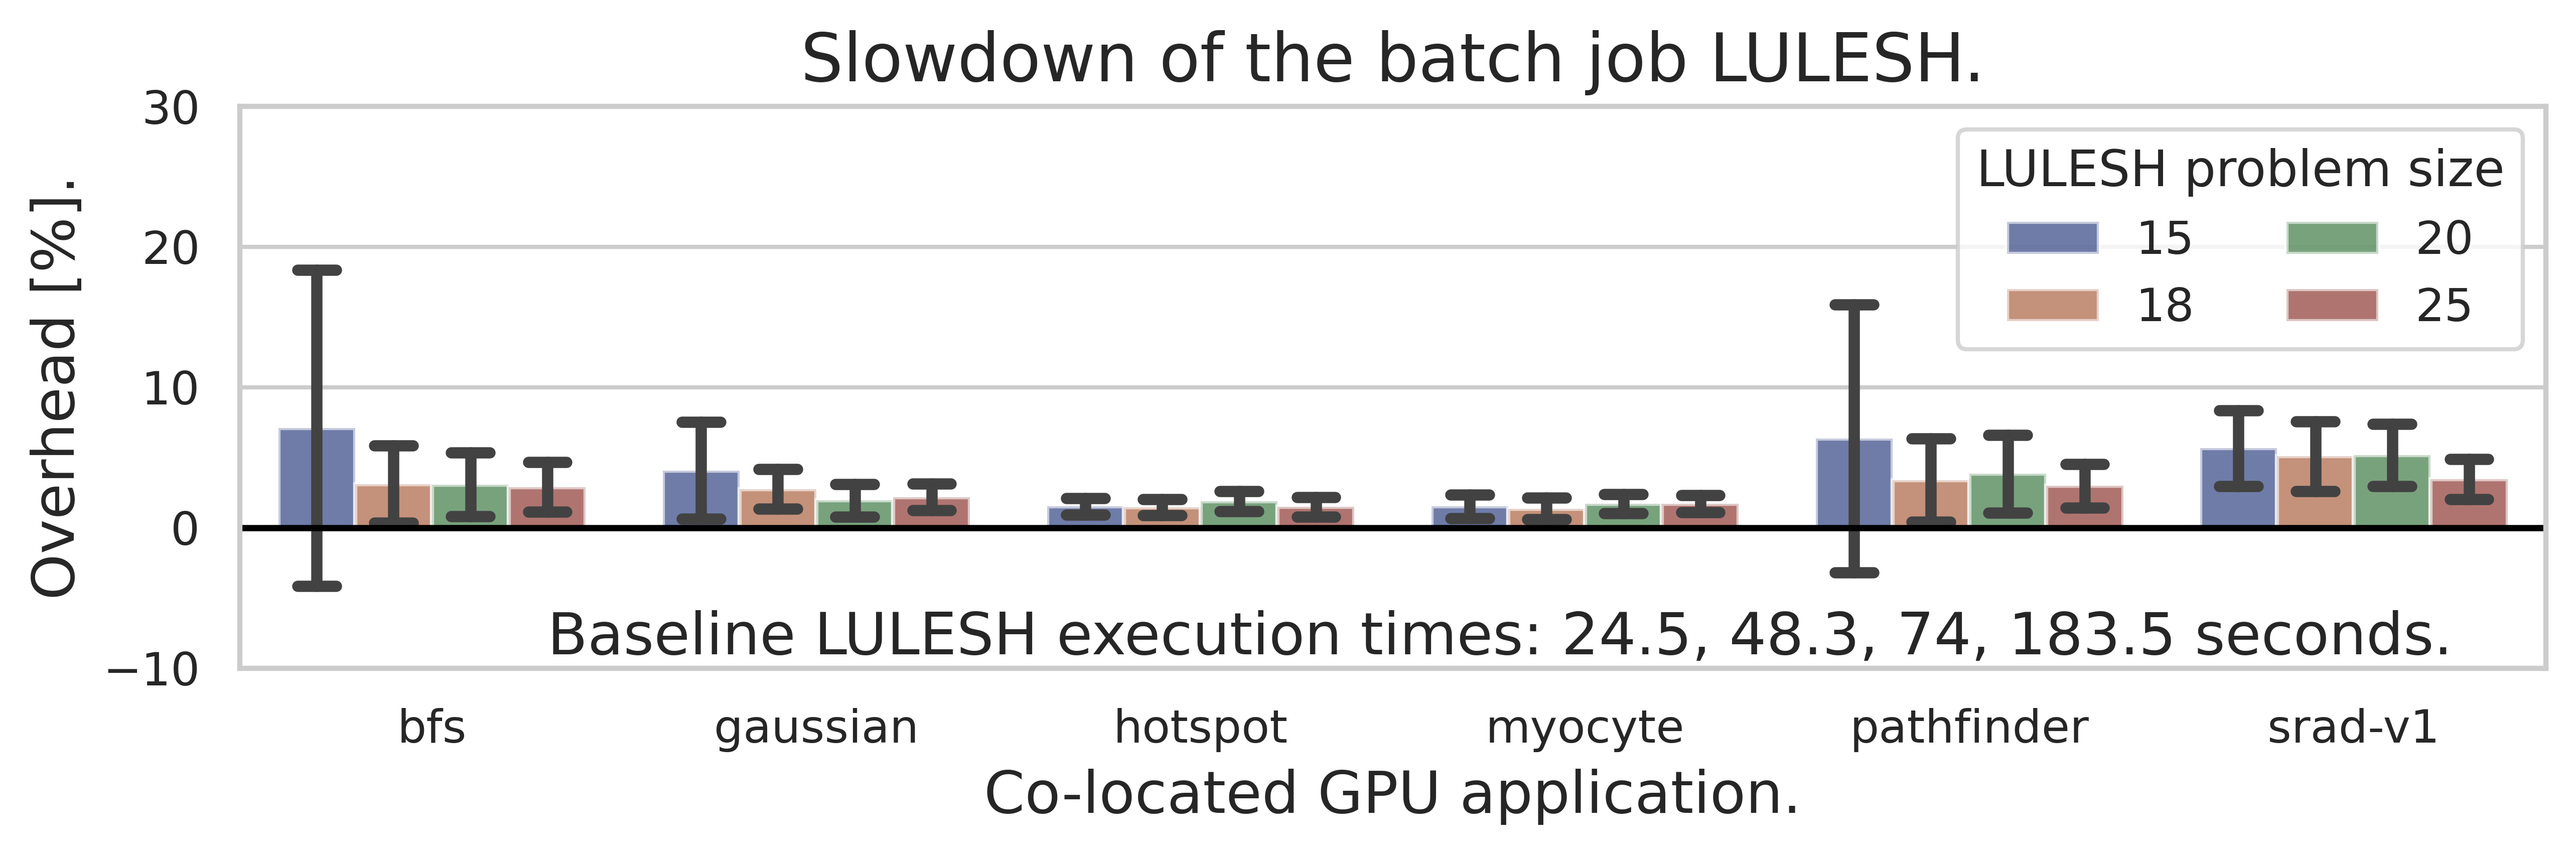

In [8]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)

g = barplot_err(y="rescaled_slowdown", x="app", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-10,30])

plt.annotate("Baseline LULESH execution times: 24.5, 48.3, 74, 183.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(0.3, -9), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots',"colocation_gpu_lulesh.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)


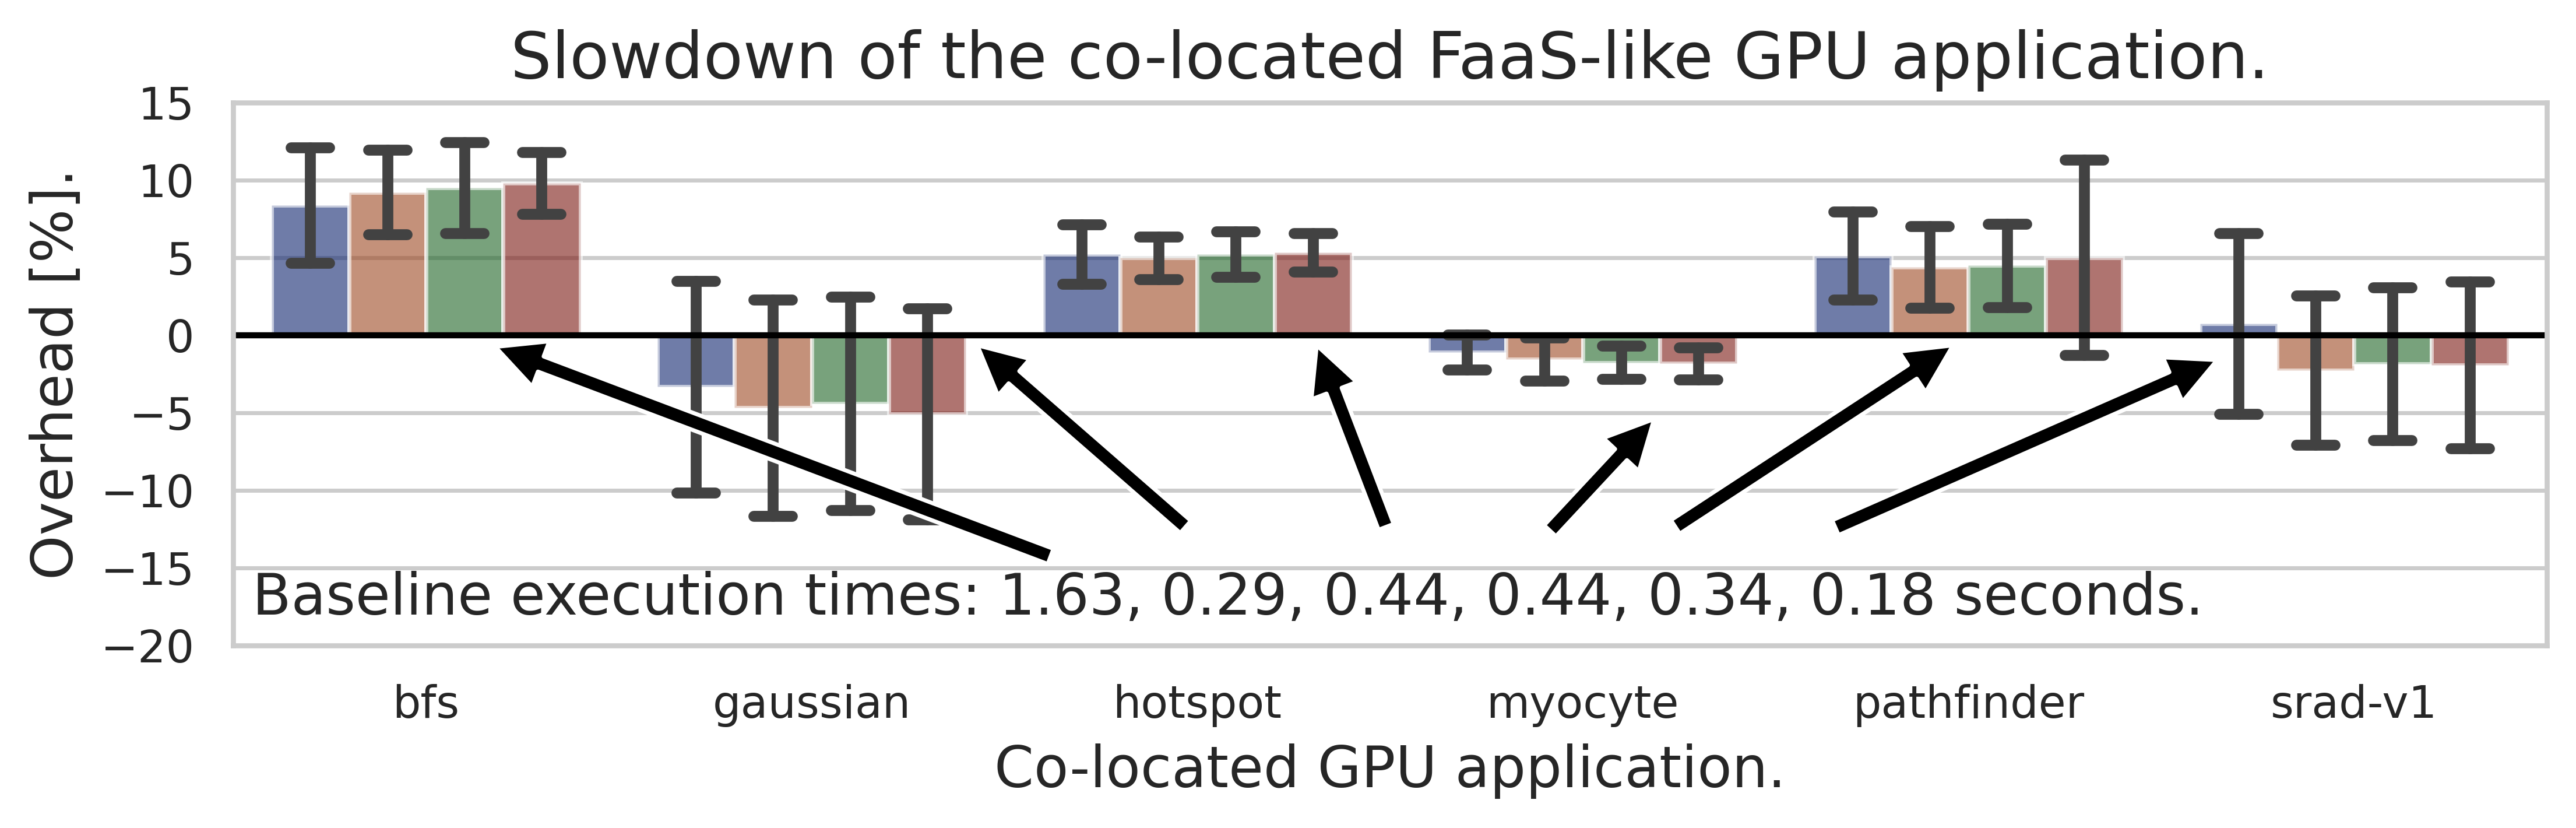

In [9]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="app_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6,#, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_app_slowdown", x="app", yerr="rescaled_app_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_title('Slowdown of the co-located FaaS-like GPU application.',fontsize=16)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-20,15])
g.set_yticks([-20, -15, -10, -5, 0, 5, 10, 15])

g.legend().set_visible(False)
plt.annotate("Baseline execution times: 1.63, 0.29, 0.44, 0.44, 0.34, 0.18 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -18), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -15),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1.4, 0),  #xycoords='data',
            xytext=(2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.3, 0),  #xycoords='data',
            xytext=(2.5, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, -5),  #xycoords='data',
            xytext=(2.9, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4, 0),  #xycoords='data',
            xytext=(3.2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.7, -1),  #xycoords='data',
            xytext=(3.6, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_gpu_lulesh_nas.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)

# Plot LULESH for Poster

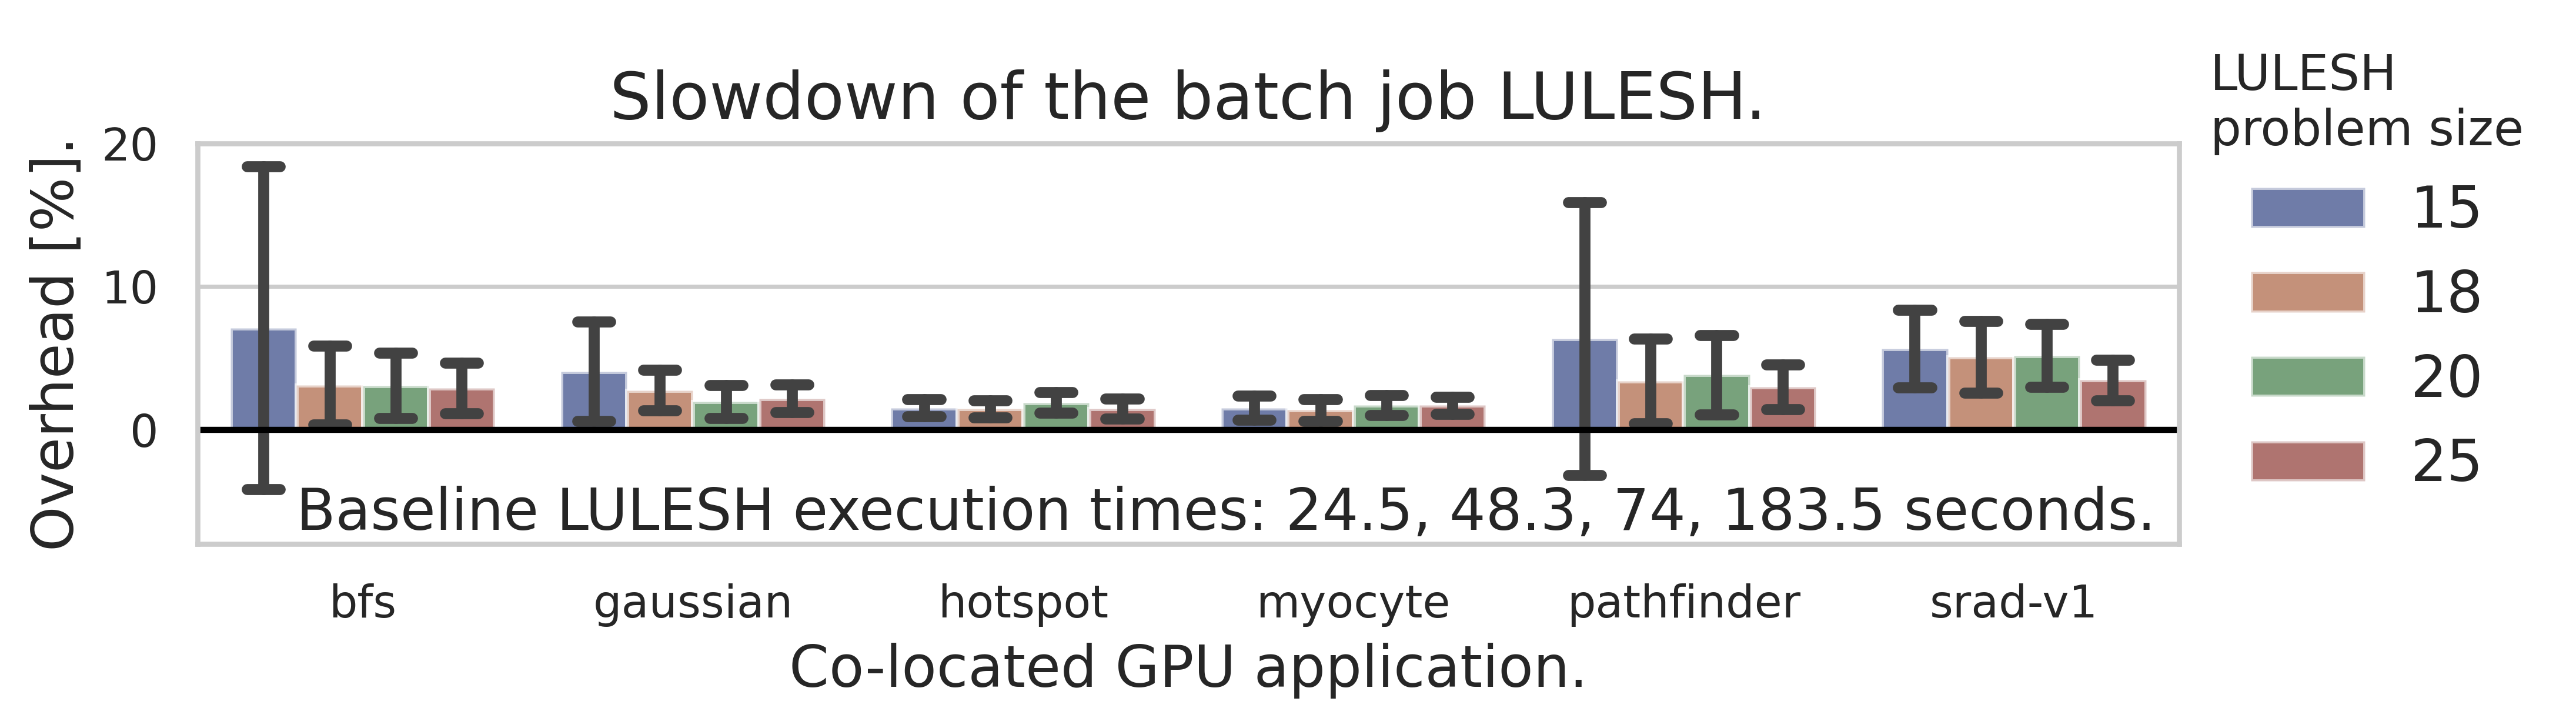

In [10]:

sns.set_style("whitegrid")
sns.set_context("notebook")
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)

g = barplot_err(y="rescaled_slowdown", x="app", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(
    title='LULESH\nproblem size',
    fontsize=14,
    ncol=1,
    bbox_to_anchor=(1.2, 0),
    loc="lower right",
    frameon=False
)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-8,20])

plt.annotate("Baseline LULESH execution times: 24.5, 48.3, 74, 183.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(-0.2, -7), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots',"colocation_gpu_lulesh_poster.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)


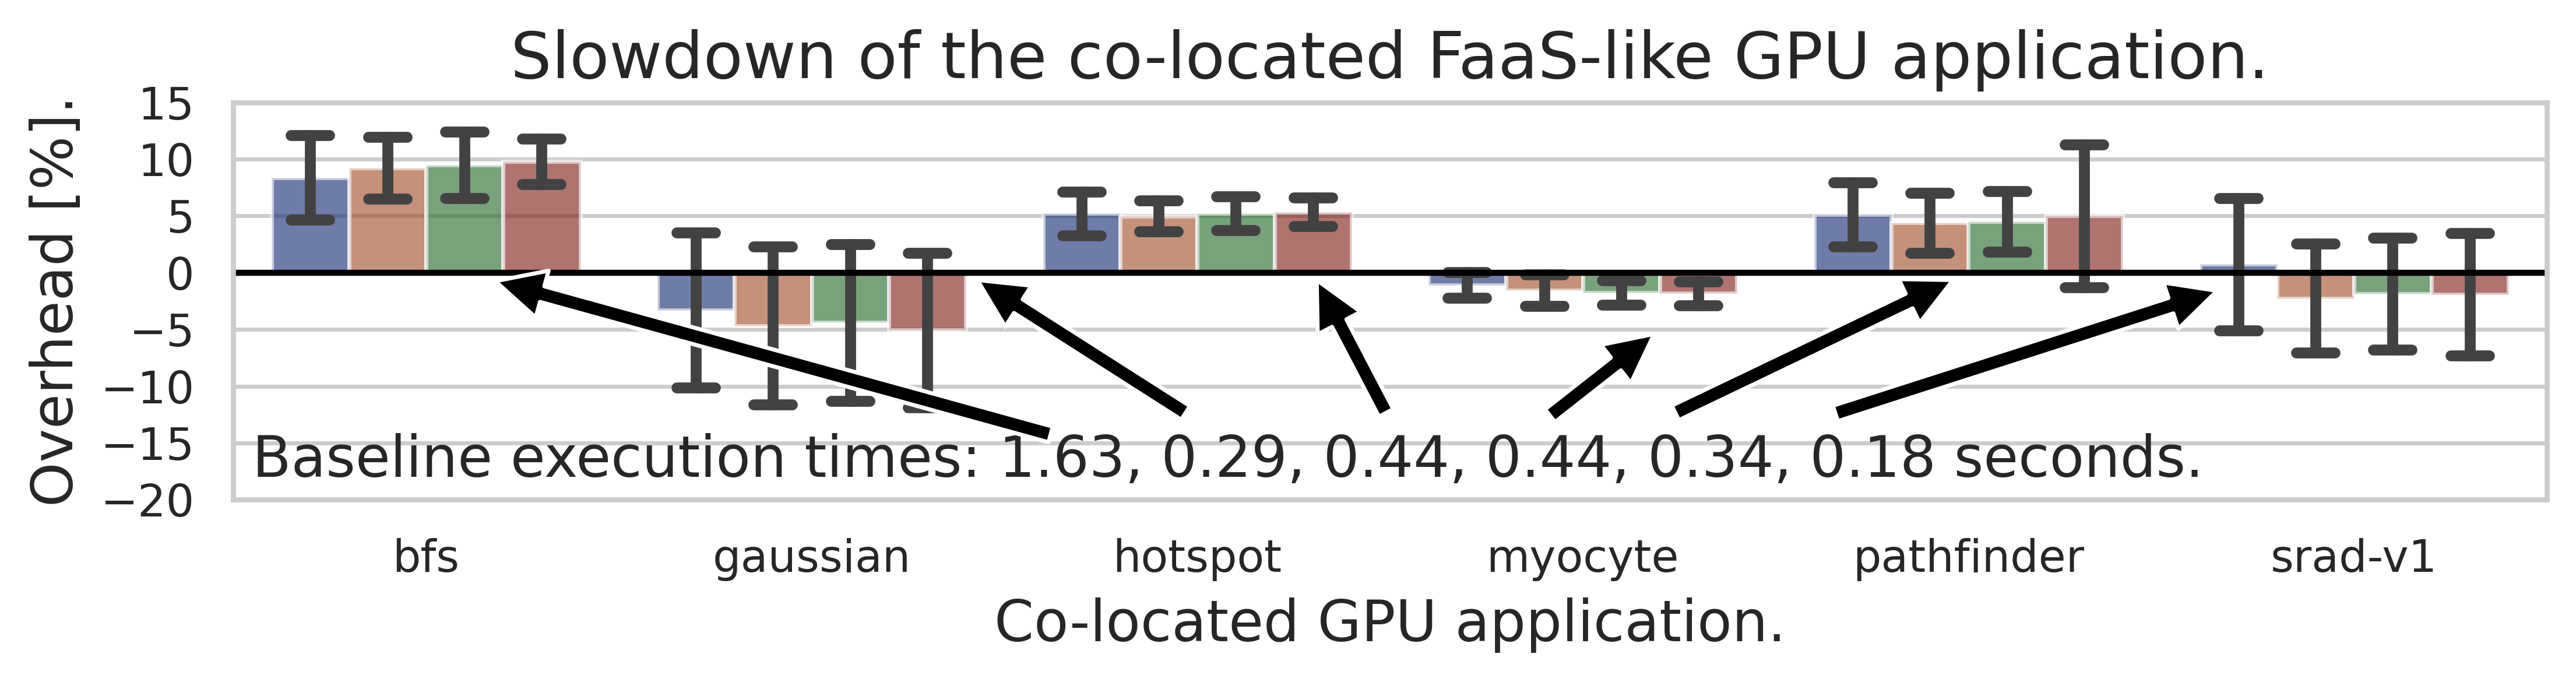

In [11]:
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="app_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6,#, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_app_slowdown", x="app", yerr="rescaled_app_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_title('Slowdown of the co-located FaaS-like GPU application.',fontsize=16)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.legend(title='LULESH problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-20,15])
g.set_yticks([-20, -15, -10, -5, 0, 5, 10, 15])

g.legend().set_visible(False)
plt.annotate("Baseline execution times: 1.63, 0.29, 0.44, 0.44, 0.34, 0.18 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -18), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -15),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1.4, 0),  #xycoords='data',
            xytext=(2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(2.3, 0),  #xycoords='data',
            xytext=(2.5, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(3.2, -5),  #xycoords='data',
            xytext=(2.9, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4, 0),  #xycoords='data',
            xytext=(3.2, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.7, -1),  #xycoords='data',
            xytext=(3.6, -13),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_gpu_lulesh_nas_poster.pdf"), bbox_inches='tight',pad_inches = 0, transparent=False)

# Plot MILC

In [12]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [11]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/daint_gpu/milc_32/milc_{spread}/milc_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed total time", fp):
                #print(line)
                size = int(f.split('_')[-2])
                data.append([11, size, float(line.split()[-1])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'lulesh_size', 'time'])
normal_lulesh = lulesh_time.loc[lulesh_time['spread'] == 11]
#print(normal_lulesh)

avg_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()
print(avg_lulesh)
print(median_lulesh)

   lulesh_size  spread        time
0           32    11.0   89.199564
1           64    11.0  171.004849
2           96    11.0  235.633898
3          128    11.0  326.827516
   lulesh_size  spread        time
0           32    11.0   89.787031
1           64    11.0  171.862714
2           96    11.0  236.313770
3          128    11.0  327.733923


In [13]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [32,64,96,128]:
        #print(f'data/colocation_gpu/milc/nas_{lulesh_size}_{app}/milc*.out')
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/milc/rodinia_{lulesh_size}_{app}/milc*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed total time", fp):
                    data.append([lulesh_size, app, float(line.split()[-1])])

colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
colocated_lulesh = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
print(colocated_lulesh)
#print(lulesh_time.loc[lulesh_time['size'] == 10]['time'])

data = []

for app in ["bfs", "gaussian", "hotspot", "myocyte", "pathfinder", "srad-v1"]:
    
    for lulesh_size in [32,64,96,128]:
        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_gpu/milc/rodinia_{lulesh_size}_{app}/{app}*.out')):
            #print(f)
            with open(f, 'r') as fp:
                line = fp.readline()
                if line != "":
                    data.append([lulesh_size, app, float(line)])

colocated_gpu = pd.DataFrame(data=data, columns=['lulesh_size', 'app', 'time'])
print(colocated_gpu)


     lulesh_size      app        time
0             32      bfs  152.977701
1             32      bfs   96.537986
2             32      bfs   96.019950
3             32      bfs   96.154645
4             32      bfs   97.795852
..           ...      ...         ...
278          128  srad-v1  401.459394
279          128  srad-v1  350.114034
280          128  srad-v1  414.759373
281          128  srad-v1  348.632368
282          128  srad-v1  362.258336

[283 rows x 3 columns]
       lulesh_size      app      time
0               32      bfs  1.877034
1               32      bfs  1.828964
2               32      bfs  1.831460
3               32      bfs  1.826857
4               32      bfs  1.829661
...            ...      ...       ...
14990          128  srad-v1  0.180370
14991          128  srad-v1  0.178937
14992          128  srad-v1  0.193707
14993          128  srad-v1  0.178505
14994          128  srad-v1  0.176351

[14995 rows x 3 columns]


In [15]:

mean_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['lulesh_size', 'app']).std().reset_index()
mean_lulesh = normal_lulesh.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['lulesh_size']).std().reset_index()

mean_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).mean().reset_index()
median_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).median().reset_index()
dev_colocated_gpu = colocated_gpu.groupby(['lulesh_size', 'app']).std().reset_index()
mean_gpu = gpu_time.groupby(['app']).mean().reset_index()
median_gpu = gpu_time.groupby(['app']).median().reset_index()
dev_gpu = gpu_time.groupby(['app']).std().reset_index()

print(mean_lulesh)
print(mean_gpu)


print(mean_lulesh)
print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

print(df1)

df3 = mean_colocated_gpu.set_index(['app'])
print(df3)
df4 = mean_gpu.set_index(['app'])
print(df4)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['original_dev'] = dev_gpu.set_index('app')['time'].reindex(df3.index)
df3['dev'] = dev_colocated_gpu.set_index('app')['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
print(df3)

df5 = df1.reset_index().set_index(['app', 'lulesh_size'])
df6 = df3.reset_index().set_index(['app', 'lulesh_size'])
print(df5)
print(df6)

df5['app_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['app_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)
#df5.sort_values(by=['type'], inplace=True)
print(df5)

#df5['slowdown'] = (df5['slowdown']-1)*100
#df5['app_slowdown'] = (df5['app_slowdown']-1)*100
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_app_slowdown'] = (df5['app_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_app_slowdown_dev'] = df5['app_slowdown_dev']*100

   lulesh_size  spread        time
0           32    11.0   89.199564
1           64    11.0  171.004849
2           96    11.0  235.633898
3          128    11.0  326.827516
          app      time
0         bfs  1.632161
1    gaussian  0.288101
2     hotspot  0.437144
3     myocyte  0.444882
4  pathfinder  0.340984
5     srad-v1  0.176451
   lulesh_size  spread        time
0           32    11.0   89.199564
1           64    11.0  171.004849
2           96    11.0  235.633898
3          128    11.0  326.827516
    lulesh_size         app        time
0            32         bfs  100.569011
1            32    gaussian   93.263840
2            32     hotspot   94.371688
3            32     myocyte  103.360674
4            32  pathfinder   91.655815
5            32     srad-v1   99.938833
6            64         bfs  186.770035
7            64    gaussian  190.261859
8            64     hotspot  189.770293
9            64     myocyte  183.295014
10           64  pathfinder  187.678629
11

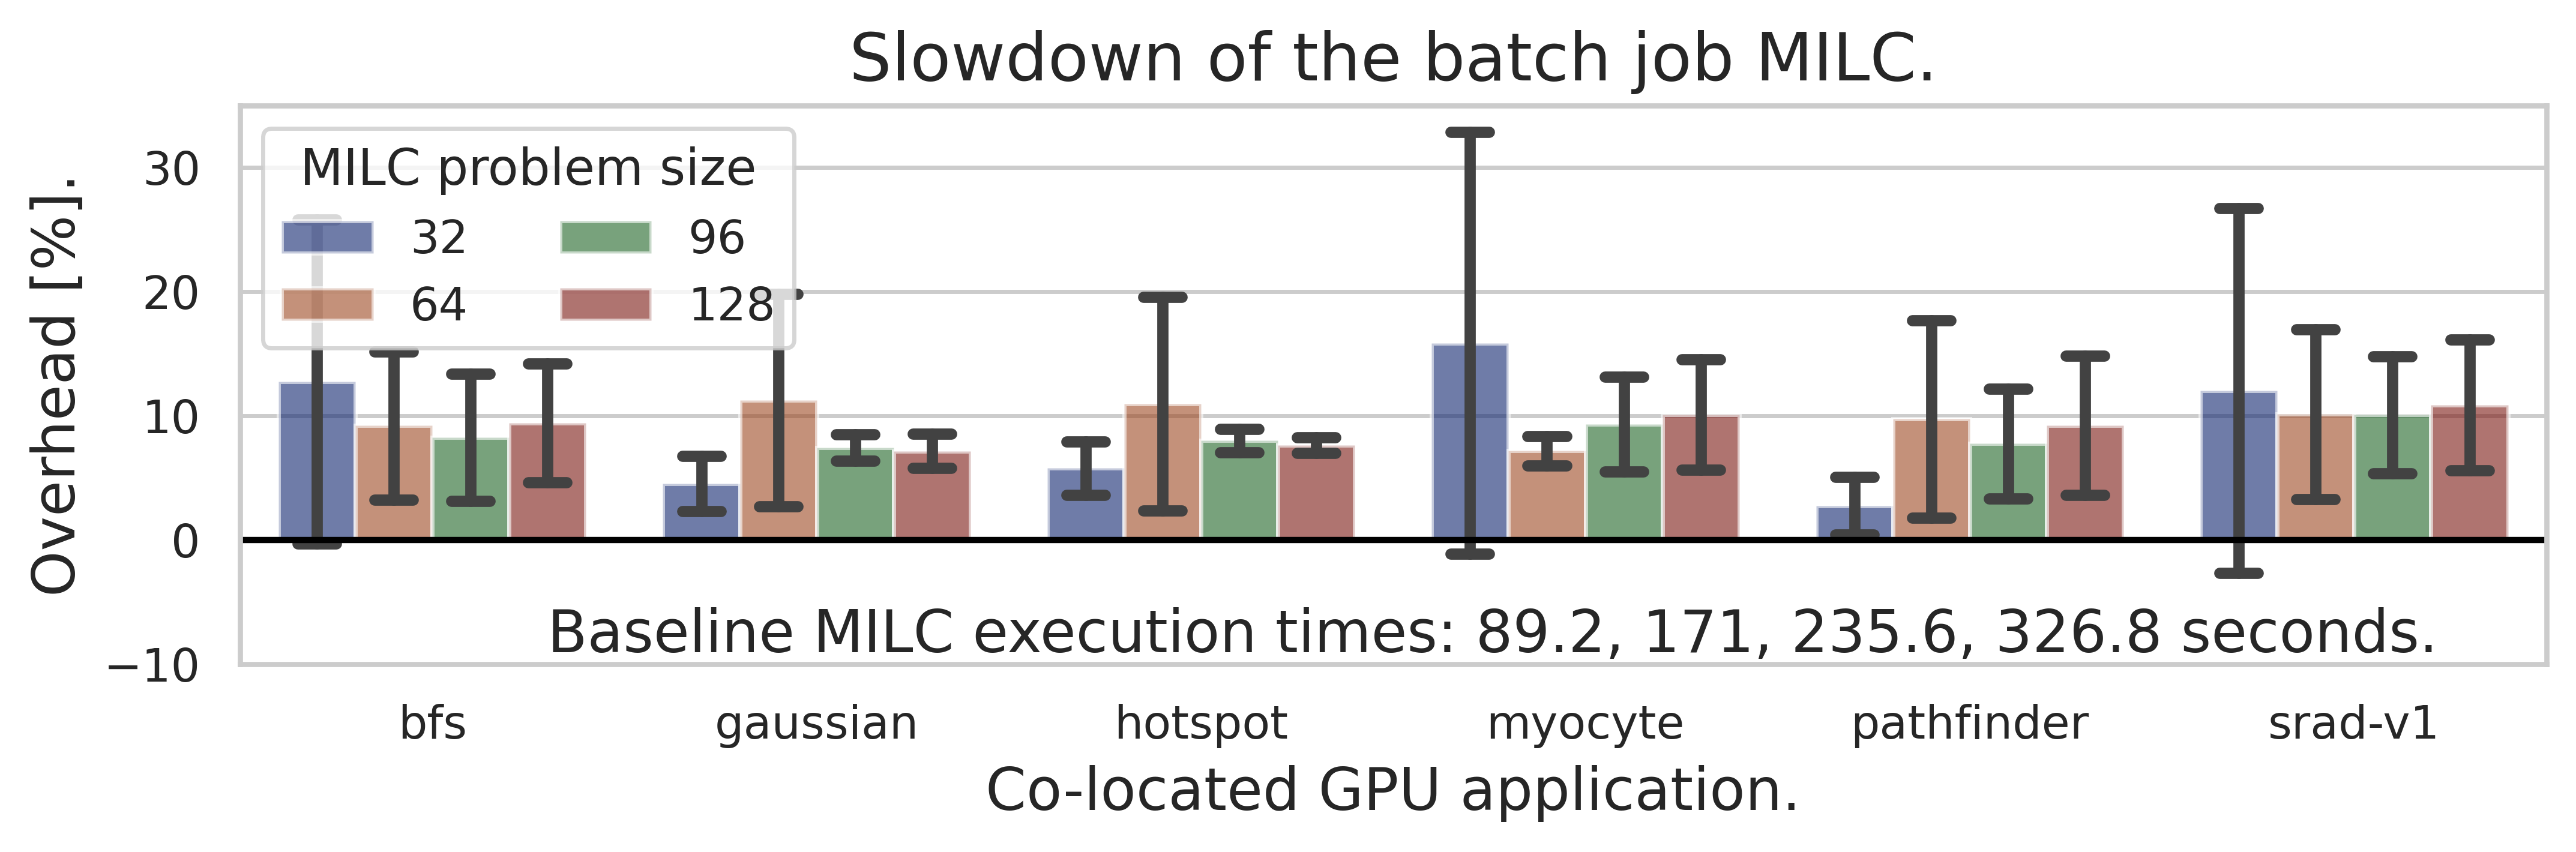

In [17]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5,
#    x="app", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)

g = barplot_err(y="rescaled_slowdown", x="app", yerr="rescaled_slowdown_dev", hue="lulesh_size",
                data=df5,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located GPU application.',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-10,35])

plt.annotate("Baseline MILC execution times: 89.2, 171, 235.6, 326.8 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(1, -2),  #xycoords='data',
            xytext=(0.3, -9), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

plt.savefig(os.path.join('plots', "colocation_gpu_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)
